In [60]:
#hide
!pip install -Uqq fastbook
import fastbook
# fastbook.setup_book()

     |████████████████████████████████| 727kB 8.5MB/s 
     |████████████████████████████████| 1.2MB 18.1MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 194kB 48.8MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 12.8MB 21.7MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [61]:
from fastbook import *

## Questionnaire

__1. What is `glob`?__

A library to get files based on wildcard searches

__2. How do you open an image with the Python imaging library?__

In [62]:
path = untar_data(URLs.IMAGENETTE_160)

__3. What does `L.map` do?__

In [63]:
from glob import glob

def get_img_files(path):  
  print(f'{path}/*/*/*.*G')
  return L(glob(f'{path}/*/*/*.*G', recursive=True)).map(Path)

files = get_img_files(path)

/root/.fastai/data/imagenette2-160/*/*/*.*G
/root/.fastai/data/imagenette2-160/*/*/*.*G


It applies the `Path` function to every cell of the list in L

__4. What does `Self` do?__

In [64]:
lbls = files.map(Self.parent.name()).unique(); lbls

(#10) ['n02102040','n02979186','n03028079','n03445777','n01440764','n03000684','n03394916','n03425413','n03888257','n03417042']

(#10) ['n02102040','n02979186','n03028079','n03445777','n01440764','n03000684','n03394916','n03425413','n03888257','n03417042']

It allows you to access a particular cell of the list

__5. What is `L.val2idx`?__

In [65]:
v2i = lbls.val2idx(); v2i

{'n01440764': 4,
 'n02102040': 0,
 'n02979186': 1,
 'n03000684': 5,
 'n03028079': 2,
 'n03394916': 6,
 'n03417042': 9,
 'n03425413': 7,
 'n03445777': 3,
 'n03888257': 8}

{'n01440764': 4,
 'n02102040': 0,
 'n02979186': 1,
 'n03000684': 5,
 'n03028079': 2,
 'n03394916': 6,
 'n03417042': 9,
 'n03425413': 7,
 'n03445777': 3,
 'n03888257': 8}

Creates a unique list of label and index

__6. What methods do you need to implement to create your own `Dataset`?__

In [66]:
# bare minimum
class Dataset():
    def __len__(self): pass
    def __getitem__(self, i): pass

__7. Why do we call `convert` when we open an image from Imagenette?__

In [67]:
img_path = files[0]

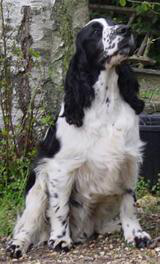

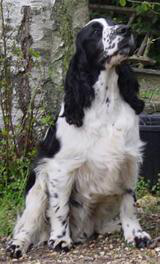

In [68]:
import PIL
PIL.Image.open(img_path)

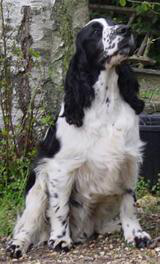

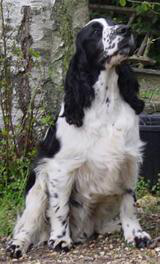

In [69]:
PIL.Image.open(img_path).convert('RGB')

It removes the alpha channel if it's present. It converts an image to a jpeg format.

__8. What does `~` do? How is it useful for splitting training and validation sets?__

`~` negates the True/False operators is in the list. 



In [70]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train = files[train_filt] # returns all places where `train_filt` is `True` in the list `files`
valid = files[~train_filt] # returns all places where `train_filt` is not `True` in the list `files`

__9. Does `~` work with the `L` or `Tensor` classes? What about NumPy arrays, Python lists, or pandas DataFrames?__

Yes it does.

__10. What is `ProcessPoolExecutor`?__

It allows for multiprocessing.

__11. How does `L.range(self.ds)` work?__

In [71]:
class Dataset:
    def __init__(self, fns): self.fns=fns
    def __len__(self): return len(self.fns)
    def __getitem__(self, i):
        im = Image.open(self.fns[i]).resize((64,64)).convert('RGB')
        y = v2i[self.fns[i].parent.name]
        return tensor(im).float()/255, tensor(y)

train_ds,valid_ds = Dataset(train),Dataset(valid)
x, y = train_ds[0]
x.shape, y.shape

(torch.Size([64, 64, 3]), torch.Size([]))

(torch.Size([64, 64, 3]), torch.Size([]))

In [72]:
L.range(train_ds)

(#9469) [0,1,2,3,4,5,6,7,8,9...]

(#9469) [0,1,2,3,4,5,6,7,8,9...]

In [73]:
[i for i in range(len(train_ds))][0:9]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

It returns a list of integers of length `ds`

__12. What is `__iter__`?__


In [74]:
def collate(idxs, ds): 
    xb,yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb),torch.stack(yb)

class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers

    def __len__(self): return (len(self.ds)-1)//self.bs+1

    def __iter__(self):
        idxs = L.range(self.ds)
        if self.shuffle: idxs = idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)

train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=16)
valid_dl = DataLoader(valid_ds, bs=128, shuffle=True, n_workers=16)
xb,yb = first(train_dl)
xb.shape,yb.shape,len(train_dl)

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

It returns the iterator

__13. What is `first`?__

Gives you the first batch in the dl

__14. What is `permute`? Why is it needed?__

We use it to convert `NHWC` to `NCHW`. PIL uses the former but we need the latter for PyTorch.


__15. What is a recursive function? How does it help us define the `parameters` method?__

A function that calls itself.



__16. Write a recursive function that returns the first 20 items of the Fibonacci sequence.__

In [75]:
def _r_fibonacci(n):
  if n==0: return 0
  if n==1: return 1
  return _r_fibonacci(n-1) + _r_fibonacci(n-2)

def get_seq_fibonacci(n):
  return [_r_fibonacci(i) for i in range(n)]

get_seq_fibonacci(20)

[0,
 1,
 1,
 2,
 3,
 5,
 8,
 13,
 21,
 34,
 55,
 89,
 144,
 233,
 377,
 610,
 987,
 1597,
 2584,
 4181]

[0,
 1,
 1,
 2,
 3,
 5,
 8,
 13,
 21,
 34,
 55,
 89,
 144,
 233,
 377,
 610,
 987,
 1597,
 2584,
 4181]

__17. What is `super`?__

It's an object that allows you to access methods of the base class


https://www.programiz.com/python-programming/methods/built-in/super#:~:text=The%20super()%20builtin%20returns,Working%20with%20Multiple%20Inheritance

__18. Why do subclasses of `Module` need to override `forward` instead of defining `__call__`?__

`__call__` is already defined in `Module`. `__call__` *calls* the forward function and runs the hooks.

__19. In `ConvLayer`, why does `init` depend on `act`?__

`Kaiming init` deals with the dying ReLU problem quite well. If we don't have any `ReLU`'s then we should probably use a different kind of init


__20. Why does `Sequential` need to call `register_modules`?__

In order to show the contents of the layer in parameters


__21. Write a hook that prints the shape of every layer's activations.__



In [76]:
class Parameter(Tensor):
    def __new__(self, x): return Tensor._make_subclass(Parameter, x, True)
    def __init__(self, *args, **kwargs): self.requires_grad_()

class Module:
    def __init__(self):
        self.hook,self.params,self.children,self._training = None,[],[],False
        
    def register_parameters(self, *ps): self.params += ps
    def register_modules   (self, *ms): self.children += ms
        
    @property
    def training(self): return self._training
    @training.setter
    def training(self,v):
        self._training = v
        for m in self.children: m.training=v
            
    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])

    def __setattr__(self,k,v):
        super().__setattr__(k,v)
        if isinstance(v,Parameter): self.register_parameters(v)
        if isinstance(v,Module):    self.register_modules(v)
        
    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None: self.hook(res, args)
        return res
    
    def cuda(self):
        for p in self.parameters(): p.data = p.data.cuda()
''
class ConvLayer(Module):
    def __init__(self, ni, nf, stride=1, bias=True, act=True):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni,3,3))
        self.b = Parameter(torch.zeros(nf)) if bias else None
        self.act,self.stride = act,stride
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_
        init(self.w)
    
    def forward(self, x):
        x = F.conv2d(x, self.w, self.b, stride=self.stride, padding=1)
        if self.act: x = F.relu(x)
        return x

class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers)

    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

class AdaptivePool(Module):
    def forward(self, x): return x.mean((2,3))

class Linear(Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni))
        self.b = Parameter(torch.zeros(nf))
        nn.init.xavier_normal_(self.w)
    
    def forward(self, x): return x@self.w.t() + self.b

In [77]:
def simple_cnn():
    return Sequential(
        ConvLayer(3,16 ,stride=2), #32
        ConvLayer(16,32 ,stride=2), #16
        ConvLayer(32,64 ,stride=2), # 8
        ConvLayer(64,128,stride=2), # 4
        AdaptivePool(),
        Linear(128, 10)
    )

In [78]:
m = simple_cnn()
len(m.parameters())

10

10

In [79]:
class Normalize:
    def __init__(self, stats): self.stats=stats
    def __call__(self, x):
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device)
        return (x-self.stats[0])/self.stats[1]

stats = [xb.mean((0,1,2)),xb.std((0,1,2))]
norm = Normalize(stats)

def tfm_x(x): return norm(x).permute((0,3,1,2))

xbt = tfm_x(xb)

In [80]:
def print_stats(outp, inp): 
  print(outp.shape)

for i in range(4): 
  m.layers[i].hook = print_stats

r = m(xbt)
r.shape

torch.Size([128, 16, 32, 32])
torch.Size([128, 32, 16, 16])
torch.Size([128, 64, 8, 8])
torch.Size([128, 128, 4, 4])


torch.Size([128, 10])

torch.Size([128, 16, 32, 32])
torch.Size([128, 32, 16, 16])
torch.Size([128, 64, 8, 8])
torch.Size([128, 128, 4, 4])


torch.Size([128, 10])

__22. What is "LogSumExp"?__

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where $a$ is the maximum of $x_{j}$.

__23. Why is `log_softmax` useful?__

Improved numerical performance. This can be useful as training can be computationally expensive.


https://datascience.stackexchange.com/questions/40714/what-is-the-advantage-of-using-log-softmax-instead-of-softmax

__24. What is `GetAttr`? How is it helpful for callbacks?__

It's a fastai class that implements standard `__getattr__` and `__dir__` methods for you.

This allows us to set up the default: `_default='learner'`




__25. Reimplement one of the callbacks in this chapter without inheriting from `Callback` or `GetAttr`.__



In [81]:
# class SetupLearnerCB(Callback):
#     _default='learner'
#     def before_batch(self):
#         xb,yb = to_device(self.batch)
#         self.learner.batch = tfm_x(xb),yb

#     def before_fit(self): self.model.cuda()

__26. What does `Learner.__call__` do?__

It returns the callback with the requested name. 

This allows for `self('before_fit')` to call `cb.before_fit()`

__27. What is `getattr`? (Note the case difference to `GetAttr`!)__

A python function for returning the method with the request name.

`GetAttr` is a fastai class (explanation in question 24)

__28. Why is there a `try` block in `fit`?__

So we can add `CancelFitException` to the fit function. This will be included in the except clause.

__29. Why do we check for `model.training` in `one_batch`?__

We could be running the model for inference. In this case we don't need to run .backward() the weights.

__30. What is `store_attr`?__

It's a function that creates self variables for us. For example:

```python
store_attr(self, 'params,lr,wd')
```

is equivalent to

```python
self.params
self.lr
self.wd
```




__31. What is the purpose of `TrackResults.before_epoch`?__

To create the following variables:

```python
self.accs,self.losses,self.ns
```

These variables will then be used later in the class

__32. What does `model.cuda` do? How does it work?__

It moves all parameters to the GPU before fit

__33. Why do we need to check model.training in LRFinder and OneCycle?__

If we're not training the model that OneCycle and LRFinder aren't really needed. So `LRFinder` and `OneCycle` should just `return`.

__34. Use cosine annealing in `OneCycle`.__


In [83]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train,valid = files[train_filt],files[~train_filt]

(9469, 3925)

(9469, 3925)

In [84]:
train_ds,valid_ds = Dataset(train),Dataset(valid)

(torch.Size([64, 64, 3]), tensor(0))

(torch.Size([64, 64, 3]), tensor(0))

In [89]:
n_workers = min(16, defaults.cpus)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=n_workers)
xb,yb = first(train_dl)
xb.shape,yb.shape,len(train_dl)

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

In [100]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)
def cross_entropy(preds, yb): return nll(log_softmax(preds), yb).mean()

In [106]:
class SGD:
    def __init__(self, params, lr, wd=0.): store_attr()
    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + p.data*self.wd) * self.lr
            p.grad.data.zero_()

In [107]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls

dls = DataLoaders(train_dl,valid_dl)

In [108]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=SGD):
        store_attr()
        for cb in cbs: cb.learner = self

    def one_batch(self):
        self('before_batch')
        xb,yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
        self('after_batch')

    def one_epoch(self, train):
        self.model.training = train
        self('before_epoch')
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(progress_bar(dl, leave=False)):
            self.one_batch()
        self('after_epoch')

    def fit(self, n_epochs):
        self('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        self('after_fit')

    def __call__(self,name):
        for cb in self.cbs: getattr(cb,name,noop)()

In [112]:
cbs = [SetupLearnerCB(),TrackResults()]
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

0 True 2.1126247079285037 0.24384834723835674


0 False 2.1022803045382163 0.2527388535031847


0 True 2.137002158358855 0.2209314605554969


0 False 2.041489973128981 0.2692993630573248


In [113]:
class LRFinder(Callback):
    def before_fit(self):
        self.losses,self.lrs = [],[]
        self.learner.lr = 1e-6

    def before_batch(self):
        if not self.model.training: return
        self.opt.lr *= 1.2

    def after_batch(self):
        if not self.model.training: return
        if self.opt.lr>10 or torch.isnan(self.loss): raise CancelFitException
        self.losses.append(self.loss.item())
        self.lrs.append(self.opt.lr)

In [114]:
lrfind = LRFinder()
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)

0 True 2.5035320849614533 0.1137395712324427


0 False 2.2977306429140127 0.11006369426751593


0 True 2.5580426094360544 0.11342274791424649


0 False 2.3705630473726114 0.09095541401273885


In [144]:
class OneCycle(Callback):
    def __init__(self, base_lr): self.base_lr = base_lr
    def before_fit(self): self.lrs = []

    def before_batch(self):
        if not self.model.training: return
        n = len(self.dls.train)
        bn = self.epoch*n + self.num
        mn = self.n_epochs*n
        pct = bn/mn
        pct_start,div_start = 0.25,10
        if pct<pct_start:
            pct /= pct_start
            lr = (1-pct)*self.base_lr/div_start + pct*self.base_lr
        else:
            pct = (pct-pct_start)/(1-pct_start)
            lr = (1-pct)*self.base_lr
        self.opt.lr = lr
        self.lrs.append(lr)

In [146]:
onecyc = OneCycle(0.1)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[onecyc])

In [147]:
learn.fit(2)

0 True 2.1779728175493718 0.1973809272362446


0 False 2.0310651373407644 0.28687898089171976


1 True 1.9433533933097475 0.32220931460555496


1 False 1.8970848676353502 0.3597452229299363


In [148]:
from fastai.callback.schedule import *

In [191]:
cosine = combined_cos(pct = .25, start = .5, middle = 1., end = 0.)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[cosine])

In [192]:
learn.fit(1)

0 True 2.1154744676708206 0.2420530151019115


0 False 1.9892435061703821 0.29095541401273883
